<a href="https://colab.research.google.com/github/shreyanknp/DA1/blob/main/Exercise_day_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-996366c36055>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Feature_1'].fillna(df['Feature_1'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 

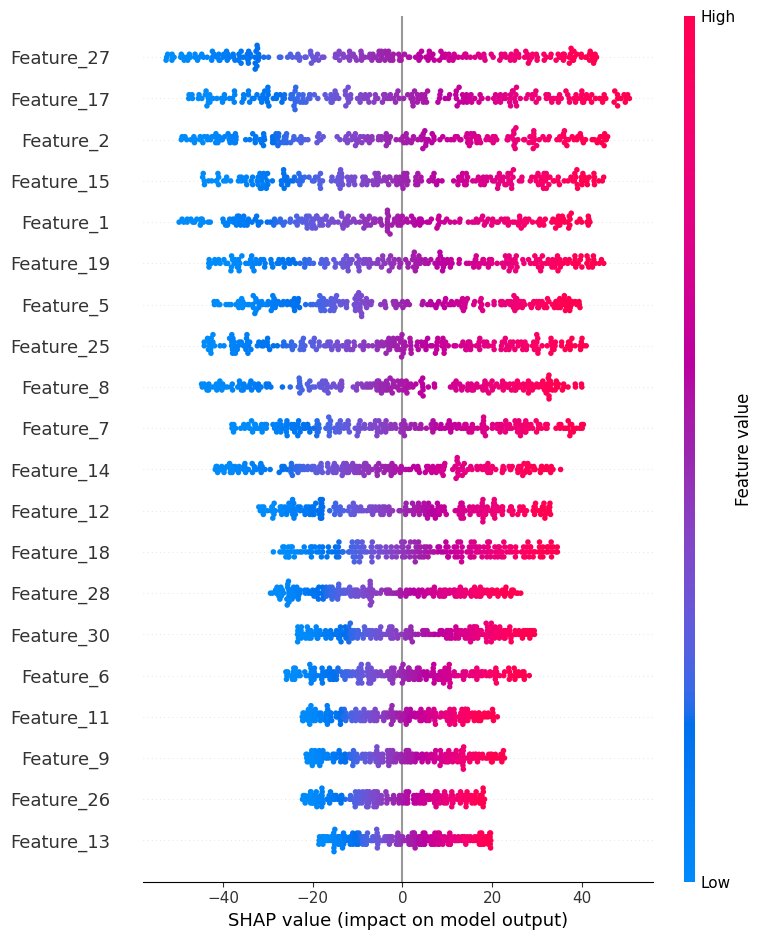

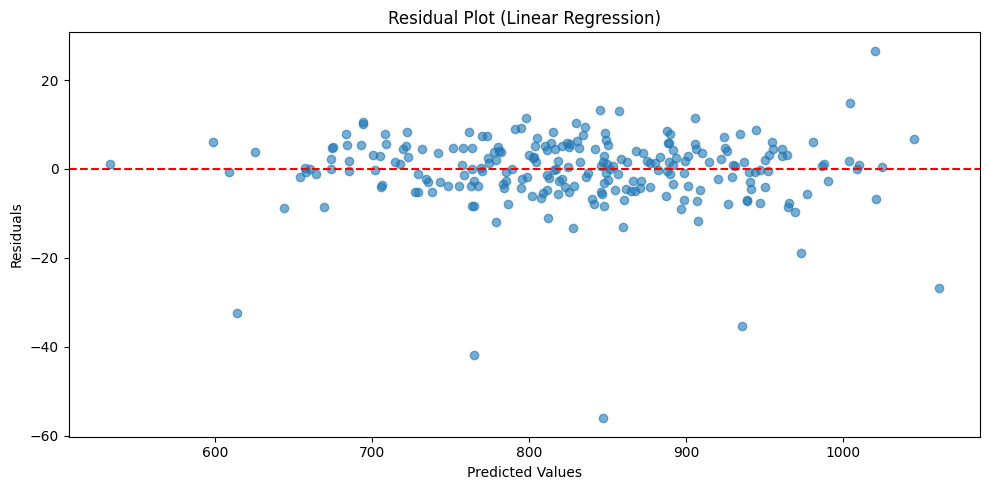

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import matplotlib.pyplot as plt
import shap

# Step 1: Generate Synthetic Data
np.random.seed(42)
n_samples = 1200  # Updated to 1200 data points
n_features = 30

X = np.random.rand(n_samples, n_features) * 100
y = np.dot(X, np.random.rand(n_features)) + np.random.normal(0, 5, size=n_samples)

# Convert to DataFrame for preprocessing
df = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(n_features)])
df['Target'] = y

# Introduce missing values and outliers
df.loc[np.random.choice(df.index, 20), 'Feature_1'] = np.nan
df.loc[np.random.choice(df.index, 20), 'Feature_2'] = df['Feature_2'].mean() + 10 * df['Feature_2'].std()

# Step 2: Preprocessing
# Handle missing values
df['Feature_1'].fillna(df['Feature_1'].mean(), inplace=True)

# Handle outliers
z_scores = np.abs((df['Feature_2'] - df['Feature_2'].mean()) / df['Feature_2'].std())
df.loc[z_scores > 3, 'Feature_2'] = df['Feature_2'].median()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.iloc[:, :-1])

# Feature Selection
# SelectKBest
kbest = SelectKBest(score_func=f_regression, k=10)
X_kbest = kbest.fit_transform(X_scaled, df['Target'])

# Recursive Feature Elimination (RFE)
lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=10)
X_rfe = rfe.fit_transform(X_scaled, df['Target'])

# Step 3: Build and Evaluate Models
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['Target'], test_size=0.2, random_state=42)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_r2 = r2_score(y_test, lr_pred)
lr_rmse = mean_squared_error(y_test, lr_pred, squared=False)

# Ridge Regression with Hyperparameter Optimization
ridge = Ridge()
ridge_params = {'alpha': [0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, scoring='r2', cv=5)
ridge_grid.fit(X_train, y_train)
ridge_pred = ridge_grid.best_estimator_.predict(X_test)
ridge_r2 = r2_score(y_test, ridge_pred)
ridge_rmse = mean_squared_error(y_test, ridge_pred, squared=False)

# Lasso Regression with Hyperparameter Optimization
lasso = Lasso(max_iter=10000)
lasso_params = {'alpha': [0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(lasso, lasso_params, scoring='r2', cv=5)
lasso_grid.fit(X_train, y_train)
lasso_pred = lasso_grid.best_estimator_.predict(X_test)
lasso_r2 = r2_score(y_test, lasso_pred)
lasso_rmse = mean_squared_error(y_test, lasso_pred, squared=False)

# Polynomial Regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, df['Target'], test_size=0.2, random_state=42)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_poly)
poly_pred = poly_model.predict(X_test_poly)
poly_r2 = r2_score(y_test_poly, poly_pred)
poly_rmse = mean_squared_error(y_test_poly, poly_pred, squared=False)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_lr = cross_val_score(lr_model, X_scaled, df['Target'], cv=kf, scoring='r2')

# SHAP Analysis
explainer = shap.Explainer(lr_model, X_train)
shap_values = explainer(X_test)

# Visualizations
# Feature Importance (SHAP)
shap.summary_plot(shap_values, X_test, feature_names=df.columns[:-1])

# Residual Plot
residuals = y_test - lr_pred
plt.figure(figsize=(10, 5))
plt.scatter(lr_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (Linear Regression)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()
